<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/analytics_vidhya/jobathon_nov22/notebooks/00_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

**Utils**

In [1]:
import gc
import os
import time
import warnings

gc.enable()
warnings.filterwarnings(action='ignore')

**Data analysis**

In [2]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

**Visualization**

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**Modeling**

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

**Reproducibility**

In [5]:
SEED = 2311
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

**Data**

In [6]:
DATA_URL = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/analytics_vidhya/jobathon_nov22/data'

train = pd.read_csv(f'{DATA_URL}/raw/train.csv', parse_dates=[1])
test = pd.read_csv(f'{DATA_URL}/raw/test.csv', parse_dates=[1])
sample_sub = pd.read_csv(f'{DATA_URL}/raw/sample_submission.csv')

# Data Overview

In [7]:
train.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.9856
1,2,2008-03-01 01:00:00,1095.5415
2,3,2008-03-01 02:00:00,1056.2475
3,4,2008-03-01 03:00:00,1034.7420
4,5,2008-03-01 04:00:00,1026.3345


In [8]:
train.tail()

,row_id,datetime,energy
94987,94988,2018-12-31 19:00:00,2528.4468
94988,94989,2018-12-31 20:00:00,2461.8836
94989,94990,2018-12-31 21:00:00,2365.9944
94990,94991,2018-12-31 22:00:00,2342.9428
94991,94992,2018-12-31 23:00:00,2180.2176


In [9]:
sample_sub.head()

,row_id,energy
0,94993,1702.995
1,94994,1702.995
2,94995,1702.995
3,94996,1702.995
4,94997,1702.995


**Datatypes and dimensions**

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    94992 non-null  int64         
 1   datetime  94992 non-null  datetime64[ns]
 2   energy    93092 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.2 MB


In [11]:
train.shape, test.shape, sample_sub.shape

((94992, 3), (26304, 2), (26304, 2))

In [12]:
(test['row_id'] == sample_sub['row_id']).sum()

26304

**Missing values**

In [13]:
train.isna().sum().sum(), test.isna().sum().sum()

(1900, 0)

Target values missing in train dataset.

**TARGET**

In [14]:
TARGET = 'energy'

In [15]:
train[TARGET].describe()

count    93092.0000
mean      1702.9950
std        369.3221
min        866.3886
25%       1431.5411
50%       1654.4658
75%       1935.9934
max       3374.3996
Name: energy, dtype: float64

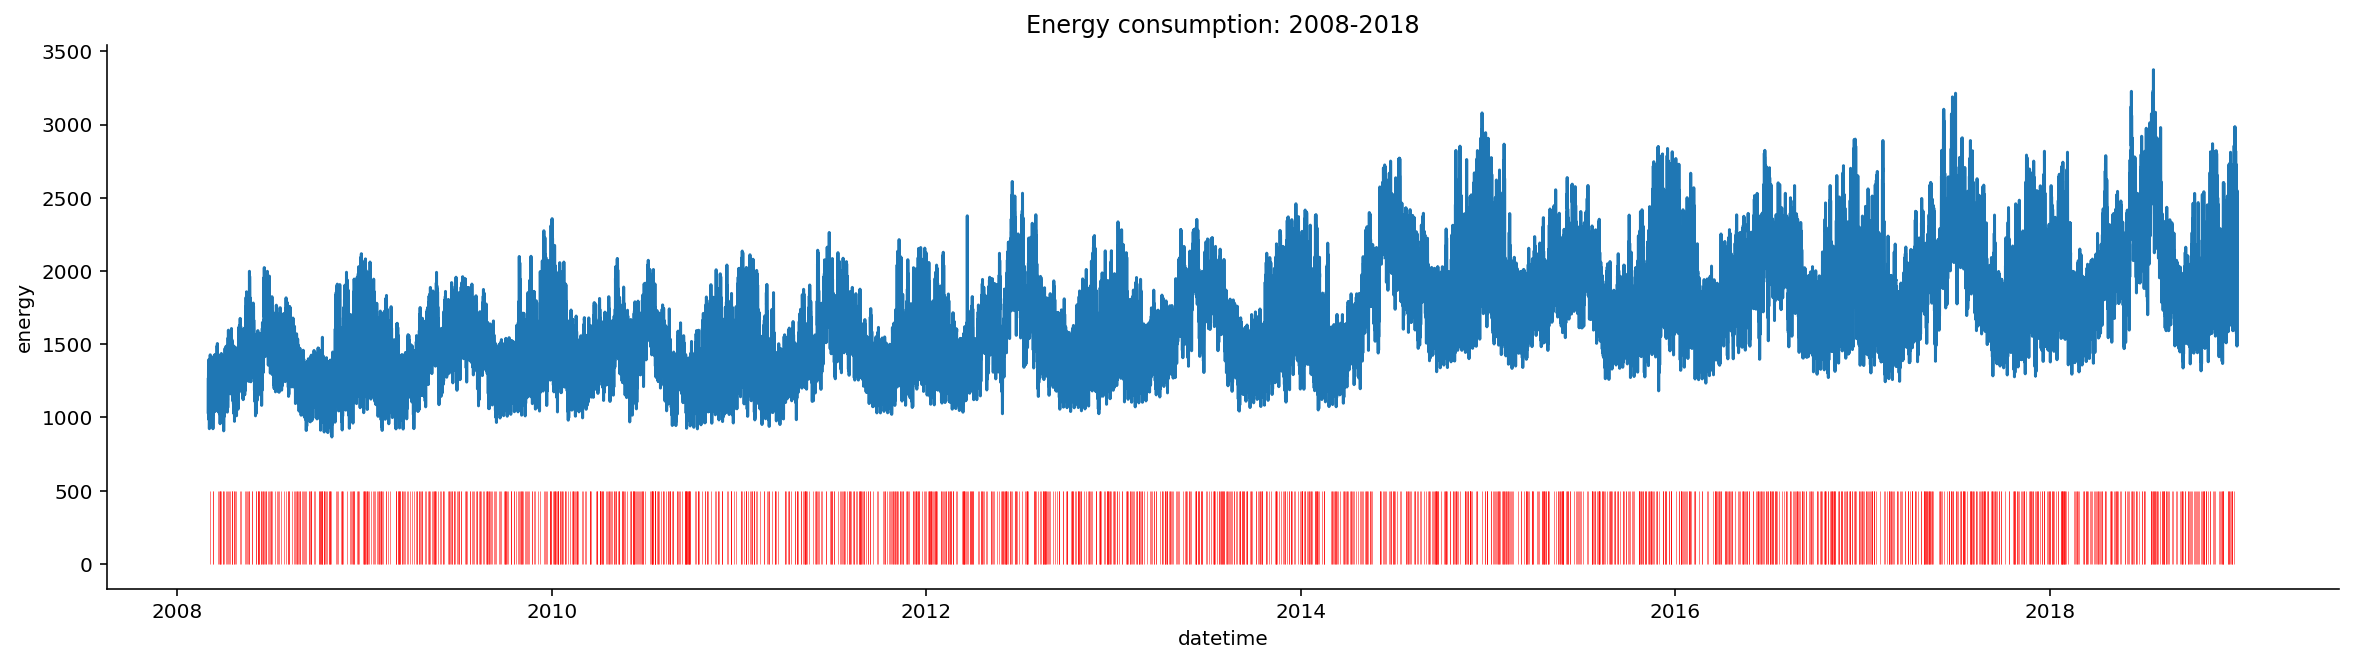

In [16]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='datetime', y=TARGET, data=train).set(title='Energy consumption: 2008-2018')
plt.vlines(x=train[train[TARGET].isna()]['datetime'], ymin=0, ymax=500, colors='r',linewidths=0.25) #missing values
plt.show()

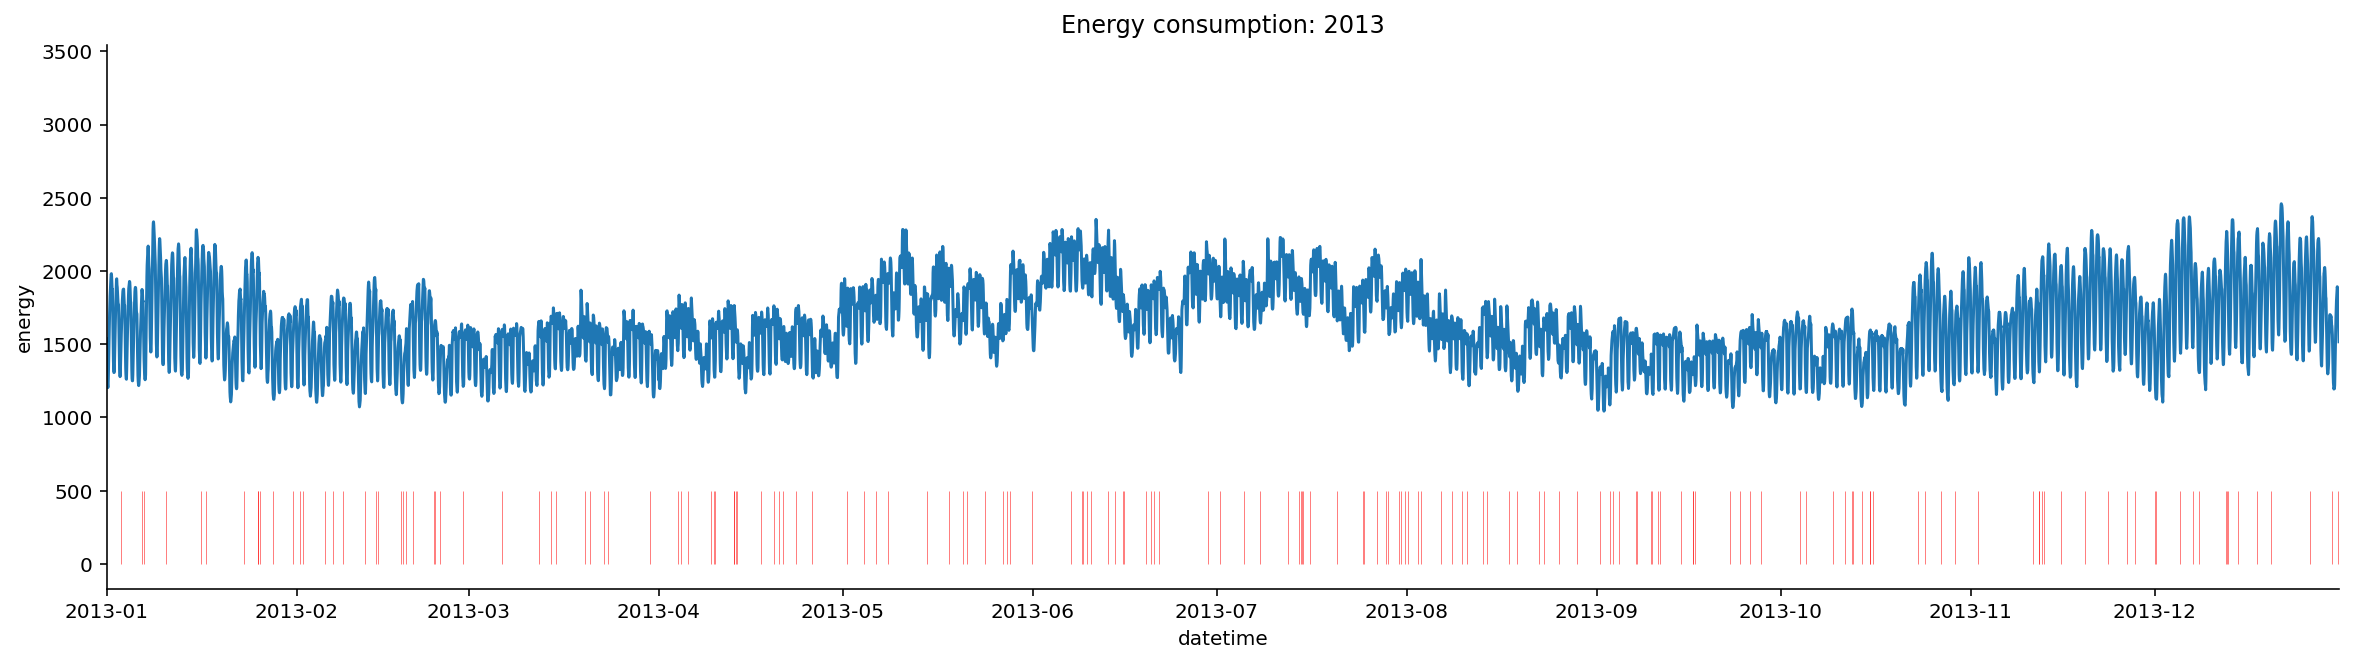

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(x='datetime', y=TARGET, data=train).set(title='Energy consumption: 2013')
plt.vlines(x=train[train[TARGET].isna()]['datetime'], ymin=0, ymax=500, colors='r',linewidths=0.25) #missing values
ax.set_xbound(lower=pd.to_datetime('2013-01-01'), upper=pd.to_datetime('2013-12-31'))
plt.show()

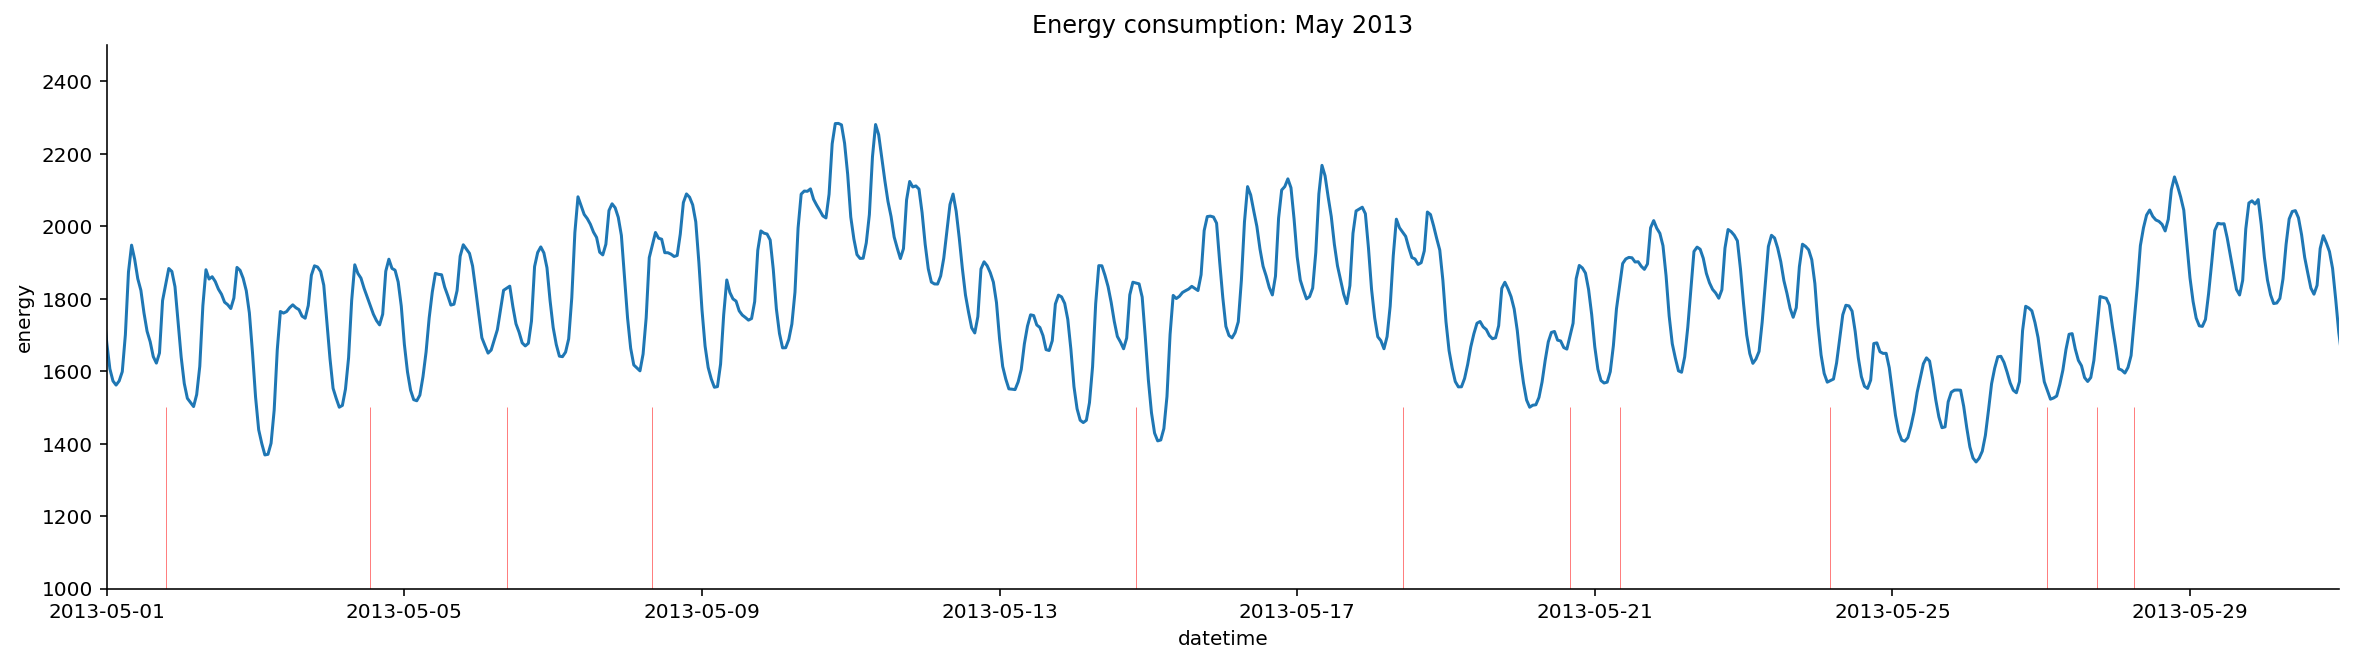

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(x='datetime', y=TARGET, data=train).set(title='Energy consumption: May 2013')
plt.vlines(x=train[train[TARGET].isna()]['datetime'], ymin=1000, ymax=1500, colors='r',linewidths=0.25) #missing values
ax.set_xbound(lower=pd.to_datetime('2013-05-01'), upper=pd.to_datetime('2013-05-31'))
ax.set_ylim(1000, 2500)
plt.show()

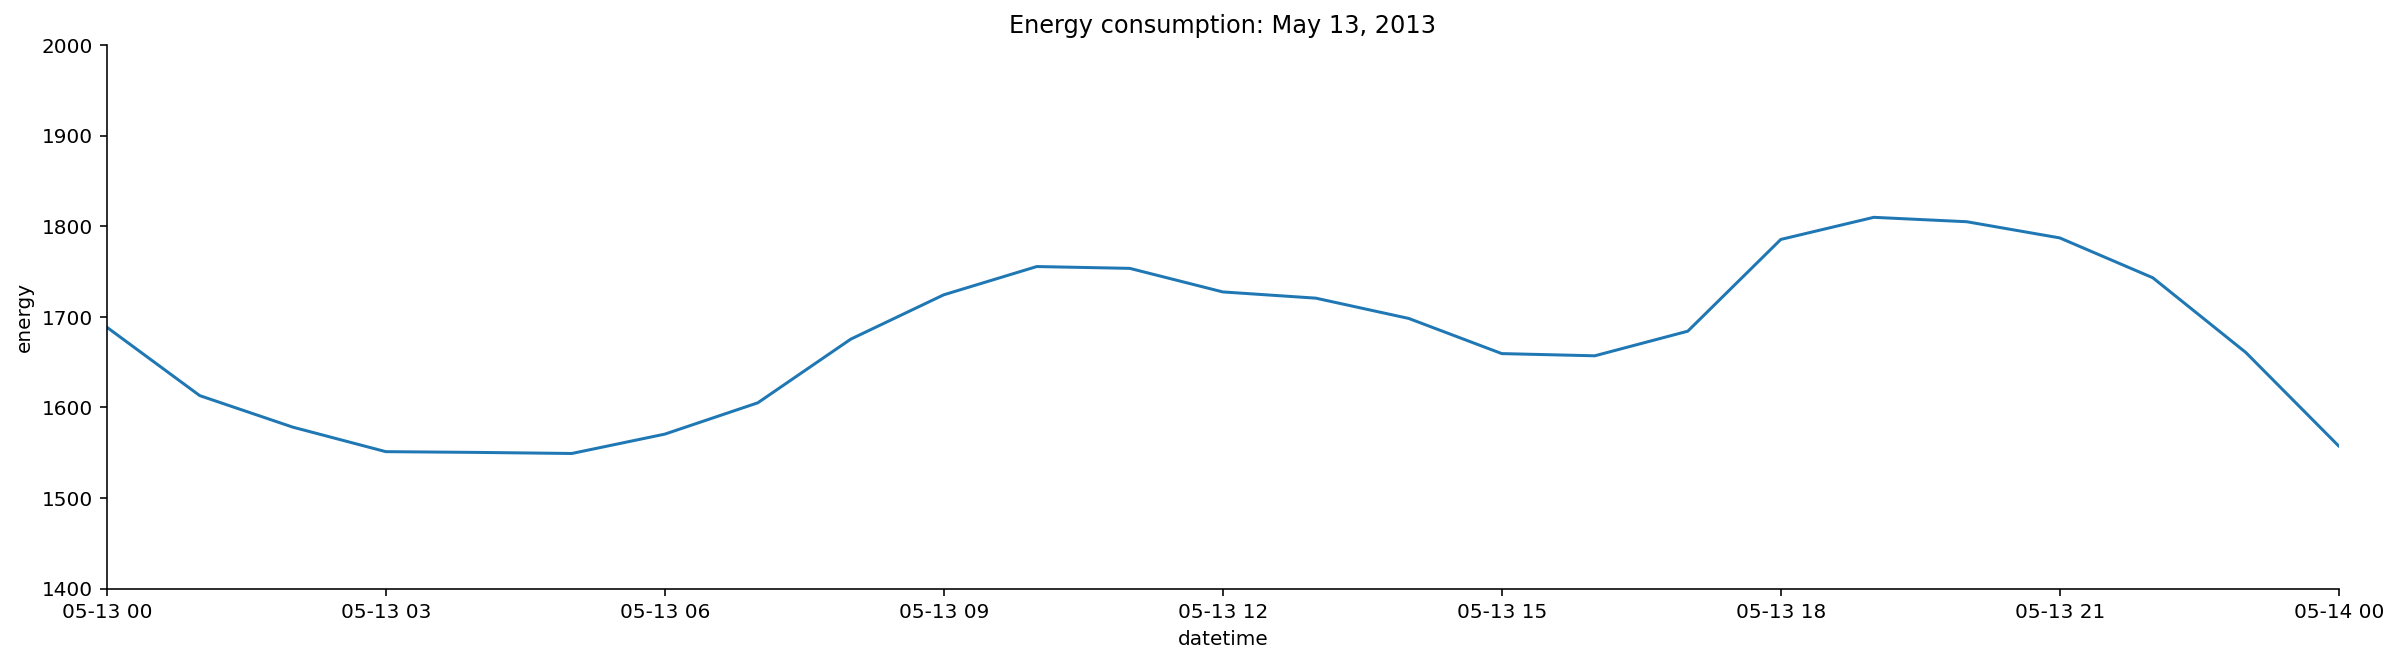

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(x='datetime', y=TARGET, data=train).set(title='Energy consumption: May 13, 2013')
plt.vlines(x=train[train[TARGET].isna()]['datetime'], ymin=1000, ymax=1500, colors='r',linewidths=0.25) #missing values
ax.set_xbound(lower=pd.to_datetime('2013-05-13'), upper=pd.to_datetime('2013-05-14'))
ax.set_ylim(1400, 2000)
plt.show()

# Feature engineering

In [20]:
train = train.drop('row_id', axis=1)
test = test.drop('row_id', axis=1)

In [21]:
def create_date_features(df):
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['quarter'] = df['datetime'].dt.quarter
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['dayofyear'] = df['datetime'].dt.dayofyear
    df['dayofmonth'] = df['datetime'].dt.day
    df['weekofyear'] = df['datetime'].dt.weekofyear

    return df

In [22]:
train = create_date_features(train)
test = create_date_features(test)

In [23]:
train.sample(5, random_state=SEED)

,datetime,energy,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
33302,2011-12-18 14:00:00,1874.8825,14,6,4,12,2011,352,18,50
61115,2015-02-19 11:00:00,1994.1856,11,3,1,2,2015,50,19,8
72236,2016-05-27 20:00:00,2239.0706,20,4,2,5,2016,148,27,21
60232,2015-01-13 16:00:00,2269.3752,16,1,1,1,2015,13,13,3
23971,2010-11-24 19:00:00,1950.3228,19,2,4,11,2010,328,24,47


In [24]:
train = train.drop('datetime', axis=1)
test = test.drop('datetime', axis=1)

In [25]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

# Handling missing values

In [26]:
train.isna().sum()

energy        1900
hour             0
dayofweek        0
quarter          0
month            0
year             0
dayofyear        0
dayofmonth       0
weekofyear       0
dtype: int64

### Approach 1: Drop rows with missing values

In [27]:
train_drop = train.dropna()

In [28]:
train_drop.shape, train.shape

((93092, 9), (94992, 9))

In [29]:
train_drop.to_csv('train_drop.csv', index=False)

### Approach 2: Front fill

In [30]:
train_ffill = train.fillna(method='ffill')

In [31]:
train_ffill.to_csv('train_ffill.csv', index=False)

### Approach 3: Back fill

In [32]:
train_bfill = train.fillna(method='bfill')

In [33]:
train_bfill.to_csv('train_bfill.csv', index=False)

### Approach 4: Linear interpolation

In [34]:
train_linear = train.interpolate(method='linear')

In [35]:
train_linear.to_csv('train_linear.csv', index=False)

### Approach 5: Polynomial interpolation (order = 3)

In [36]:
train_poly3 = train.interpolate(method='polynomial', order=3)

In [37]:
train_poly3.to_csv('train_poly3.csv', index=False)

### Approach 6: Polynomial interpolation (order = 5)

In [38]:
train_poly5 = train.interpolate(method='polynomial', order=5)

In [39]:
train_poly5.to_csv('train_poly5.csv', index=False)

### Approach 7: Iterative imputer

In [49]:
%%time
imputer = IterativeImputer(
    sample_posterior=True,
    max_iter=1000,
    initial_strategy='median',
    min_value=850,
    max_value=3400,
    verbose=0,
    random_state=SEED
)

train_iterimp = pd.DataFrame(data=imputer.fit_transform(train), columns=train.columns)

CPU times: user 13min 10s, sys: 7min 1s, total: 20min 11s
Wall time: 11min 46s


In [52]:
features = list(test.columns)
train_iterimp[features] = train_iterimp[features].astype('int')

In [53]:
train_iterimp.to_csv('train_iterimp.csv', index=False)